In [1]:
# импорт всех необходимых функций
from help_functions import *

## Задача 1

In [2]:
def f(x):
    return np.arccos(x)

# max производных arccos
max_derivs = [1, 1.17188, 1, 1.17188, 1] # – может ошибка тут?? но вроде нет

def get_table1():
    n = 4
    interp_point = 0.35
    # задаем функцию
    f = lambda x: np.arccos(x)
    # список теоритических границ
    bounds = []
    for i in range(n):
        x = np.array([0, 0.1, 0.2, 0.3, 0.5, 0.6])
        y = np.array([f(k) for k in x])
        x, y = nearest_points(x, y, interp_point, i + 1)
        bound = np.abs(np.prod(interp_point - np.array(x))) * max_derivs[i] / math.factorial(i + 1)
        bounds.append(bound)
    
    # список абсолютных погр мн-в разных степеней
    Rs = [] 
    for i in range(n):
        x = np.array([0, 0.1, 0.2, 0.3, 0.5, 0.6])
        y = np.array([f(k) for k in x])
        
        x, y = nearest_points(x, y, interp_point, i + 1)
        print(x)
        coefs = newton_coefs(x, y)
        # считаем значение многочлена в точке
        value = value_at_point(interp_point, coefs, x)
        R = np.abs(value - f(interp_point))
        # добавляем в список полученную абсолютную погрешность
        Rs.append(R)
    
    return pd.DataFrame({'R': Rs, 'граница': bounds})

In [3]:
# значения получаются странными (граница меньше R, но коэф-ты перепроверяла, максимумы производных вроде как тоже верные)
# не понятно
get_table1()

[0.3]
[0.3, 0.2]
[0.3, 0.2, 0.5]
[0.3, 0.2, 0.5, 0.1]


,R,граница
0,0.052878,0.050000
1,0.001211,0.004395
2,0.000318,0.000187
3,0.000046,0.000014


In [4]:
def get_table2():
    # по равностоящим узлам
    a = 0.5
    b = 1.5
    n = 4
    # шаг
    h = 0.1
    f = lambda x: np.cos(x)
    # дробим отрезок на части длиной h
    x = np.linspace(a, b, int((b - a) / h)  + 1)
    y = [f(z) for z in x]
    interp_point = 0.45
    t = (interp_point - a) / h

    table = np.zeros((n + 1, 6))
    for k in range(n + 1):
        ds_y0 = finite_differences(y, k) # считаем разности 
        dk_y0 = ds_y0[-1]
        nk = get_Nk(t, k)
        nk_delta = nk * dk_y0
        pk = get_Pk(ds_y0, t, k)

        # оценка погрешности
        m_kpo = np.abs(max_derivs[k])
        n_kpo = get_Nk(t, k + 1)
        th_R = np.abs(n_kpo) * m_kpo * h ** (k + 1)
        # записываем в таблицу
        table[k] = np.array([dk_y0, nk, nk_delta, pk, f(interp_point) - pk, th_R])
        
    index = ['∆k*y0', 'N_k(t)', 'N_k*∆k*y0',
            f'P_k({interp_point})', f'f({interp_point}) - P_k({interp_point})',
            f'|R_k({interp_point})| <=']
    return pd.DataFrame(table.T, index=index)

In [5]:
get_table2()

,0,1,2,3,4
∆k*y0,0.877583,-0.052247,-0.008246,0.000604,0.000076
N_k(t),1.000000,-0.500000,0.375000,-0.312500,0.273438
N_k*∆k*y0,0.877583,0.026123,-0.003092,-0.000189,0.000021
P_k(0.45),0.877583,0.903706,0.900614,0.900425,0.900446
f(0.45) - P_k(0.45),0.022865,-0.003259,-0.000167,0.000022,0.000002
|R_k(0.45)| <=,0.050000,0.004395,0.000313,0.000032,0.000002


## Задание 2

In [6]:
def f(x):
    return np.arccos(x)

x = np.array([0, 0.1, 0.2, 0.3, 0.5, 0.6])
y = np.array([f(i) for i in x])
interp_point = 0.35
x, y = nearest_points(x, y, interp_point, len(x)) # построим многочлен 5й степени

coefs = newton_coefs(x, y)
print(coefs)

[1.266103672779499, -1.0333473322506672, -0.20394425221279877, -0.2418314309950376, -0.23816127753504696, -0.213694653177382]


In [7]:
x_var = sp.symbols('x')
polynom = sympy_poly(x, y, x_var, coefs)

true_value = 0.75
true_point = np.cos(true_value)
polynom

-1.03334733225067*x - 0.213694653177382*(x - 0.6)*(x - 0.5)*(x - 0.3)*(x - 0.2)*(x - 0.1) - 0.238161277535047*(x - 0.5)*(x - 0.3)*(x - 0.2)*(x - 0.1) - 0.241831430995038*(x - 0.5)*(x - 0.3)*(x - 0.2) - 0.203944252212799*(x - 0.3)*(x - 0.2) + 1.5761078724547

In [8]:
root = newton_root(polynom - true_value, 0.5, 0.000001, 100)

решение нашлось после 3 итераций.


In [9]:
estimation = float(polynom.subs({x_var : root}))
pd.DataFrame([true_point, root, root - true_point, true_value, estimation],
             index=['настоящая точка', 'корень', 'ошибка', 'настоящее значение', 'приближение'], columns=[''])

,
настоящая точка,0.731689
корень,0.732664973336608
ошибка,0.000976104462787175
настоящее значение,0.75
приближение,0.75


## Задание 3

In [10]:
def f(x):
    return 1 / (1 + x**2)
# по корням мн-на
interp_point = 0.15
n = 7
x = [np.cos(np.pi * (2 * k + 8) / 22) for k in range(n)]
y = [f(i) for i in x]

x, y = nearest_points(x, y, interp_point, n) 
coefs = newton_coefs(x, y)
estimation = value_at_point(interp_point, coefs, x)

pd.DataFrame({'приближение': [estimation], 'Рунге': [f(interp_point)], 'ошибка': [np.abs(estimation - f(interp_point))]})

,приближение,Рунге,ошибка
0,0.977887,0.977995,0.000108


In [11]:
# по равностоящим узлам
a = -1
b = 1
h = (b - a) / (n - 1)
x = np.linspace(a, b, n)
y = [f(i) for i in x]
t = interp_point / h

In [12]:
ds_y0 = finite_differences2(y, n - 1)
ds_y0 = [ds_y0[k][3 - k // 2] for k in range(n)] # получаем средний ряд
# считаем Nk
Nks = [1]
for i in range(1, n): Nks.append(Nks[-1] * (t - (-1)**i * (i // 2)) / i)
estimation = 0
for i, j in zip(ds_y0, Nks):
    estimation += i * j

In [13]:
pd.DataFrame({'приближение': [estimation],
              'Рунге': [f(interp_point)],
              'ошибка': [np.abs(estimation - f(interp_point))]})

,приближение,Рунге,ошибка
0,0.978246,0.977995,0.000251


## Задача 4

In [14]:
x = [-2, -2, -2, 1]
y = [24, 24, 24, 12]
dy = [39, 39, 39, None]
d2y = [-42, -42, -42, None]
# сортируем
inds = [m[1] for m in sorted(zip(x, range(len(x))))]
x = [x[i] for i in inds]
y = [y[i] for i in inds]
dy = [dy[i] for i in inds]
d2y = [d2y[i] for i in inds]
# производные 
derivatives = [y, dy, d2y]
# порядок
order = 5
# коэф-ты
coefs = divided_differences(x, y, order, derivatives)
print(coefs)

[24, 39.0, -21.0, 2.222222222222222]


In [15]:
# получаем многочлен по коэф-там
polynom = sympy_poly(x, y, x_var, coefs)
polynom

39.0*x + 2.22222222222222*(x + 2)**3 - 21.0*(x + 2)**2 + 102.0

In [16]:
# проверка
print(polynom.subs({x_var: -2}), '- значение в -2')
print(polynom.subs({x_var: 1}), '- значение в 1')
print(diff(polynom).subs({x_var: -2}), '- первая производная в -2')
print(diff(diff(polynom)).subs({x_var: -2}), '- вторая производная в -2')

24.0000000000000 - значение в -2
12.0000000000000 - значение в 1
39.0000000000000 - первая производная в -2
-42.0000000000000 - вторая производная в -2


## Задача 6

## 1

wolfram: 
$$ \int_{0}^{1}\frac{\cos(x)}{\sqrt{x}} dx = 1.80905$$

## 2

In [17]:
simpson = (1 - 0) * np.cos(0.5)/np.sqrt(0.5)
simpson

1.2410891611274912

## 3

In [18]:
#узлы
nodes = np.array([1/4, 3/4])
#моменты весовой функции
moment = np.array([2, 2/3, 2/5, 2/7])
#коэфициенты
A = []
A.append((moment[0]*nodes[1]-moment[1])/(nodes[1]-nodes[0]))
A.append((moment[1]-moment[0]*nodes[0])/(nodes[1]-nodes[0]))
#приближенное значение интеграла
quadrature = 0
for i in range(2):
    quadrature += A[i]*np.cos(nodes[i])
quadrature

1.8587503258090148

## 4

In [19]:
#моменты уже посчитаны в пункте 3
#ищем коэфициенты многочлена
M1 = []
v1 =[]
for i in range(2):
    M1.append([moment[i], moment[i+1]]) 
    v1.append(-moment[i+2])
a0 = 3/35
a1 = -6/7
#находим корни -узлы
w = x_var ** 2 + a1 * x_var + a0
root = sp.solve(w)
#
A = []
A.append((moment[0]*root[1]-moment[1])/(root[1]-root[0]))
A.append((moment[1]-moment[0]*root[0])/(root[1]-root[0]))
quadrature = 0
for i in range(2):
    quadrature += A[i]*np.cos(float(root[i]))
print(quadrature)

1.80861639537771


## Задание 5

In [20]:
def f(x):
    return np.exp(2 * x)
interp_point = 1.0
a = 0
b = 2
h = 0.1 
x = np.linspace(a, b, int((b - a) / h + 1))
y = [f(i) for i in x]

In [21]:
def get_table4(x, y, h, return_df=True):
    # считаем производные
    fod_values_1 = first_order_deriv_1(x, y, h)
    fod_values_2 = first_order_deriv_2(x, y, h)
    sod_values_2 = second_order_deriv(x, y, h)
    td_values_1 = true_first_order_deriv(x)
    td_values_2 = true_second_order_deriv(x)
    
    
    error_1 = td_values_1 - fod_values_1 # O(h)
    error_2 = td_values_1 - fod_values_2 # O(h^2)
    second_error_2 = td_values_2 - sod_values_2 # O(h^2)

    df_dict = {'x': x, 'f(x)': y, "f'": td_values_1, "~f'": fod_values_1, "O(h)": error_1,
               "~~f'": fod_values_2, "O(h^2)": error_2, 'f"': td_values_2, '~f"': sod_values_2,
               'O(h^2)_second': second_error_2 }
    
    df = pd.DataFrame(df_dict).iloc[1:-5]
    if return_df:
        return df
    # возвращаем только нужную ошибку для eval_point
    return df[df.x == interp_point].iloc[0]['O(h^2)']

In [22]:
get_table4(x, y, h)

,x,f(x),f',~f',O(h),~~f',O(h^2),"f""","~f""",O(h^2)_second
1,0.1,1.221403,2.442806,2.704219,-0.261414,2.459123,-0.016318,4.885611,4.901918,-0.016307
2,0.2,1.491825,2.983649,3.302941,-0.319292,3.003580,-0.019931,5.967299,5.987216,-0.019918
3,0.3,1.822119,3.644238,4.034221,-0.389984,3.668581,-0.024344,7.288475,7.312803,-0.024327
4,0.4,2.225541,4.451082,4.927409,-0.476327,4.480815,-0.029733,8.902164,8.931877,-0.029713
5,0.5,2.718282,5.436564,6.018351,-0.581787,5.472880,-0.036316,10.873127,10.909419,-0.036292
6,0.6,3.320117,6.640234,7.350830,-0.710597,6.684591,-0.044357,13.280468,13.324795,-0.044327
7,0.7,4.055200,8.110400,8.978325,-0.867925,8.164578,-0.054178,16.220800,16.274941,-0.054141
8,0.8,4.953032,9.906065,10.966150,-1.060086,9.972237,-0.066173,19.812130,19.878258,-0.066129
9,0.9,6.049647,12.099295,13.394086,-1.294791,12.180118,-0.080823,24.198590,24.279359,-0.080770
10,1.0,7.389056,14.778112,16.359574,-1.581462,14.876830,-0.098718,29.556224,29.654877,-0.098652


In [23]:
def get_optimal_h():
    # уменьшаем в 2 раза постепенно
    factor = 1.0 
    min_error = 999999 # минимальная ошибка за все время

    k = 0
    # максимальное число итераций
    maxk = 200
    while k < maxk:
        # пересчитываем узлы с новым шагом
        x = np.linspace(a, b, int((b - a) / (h * factor) + 1))
        y = [f(i) for i in x]
        cur_error = np.abs(get_table4(x, y, h * factor, False)) # O(h^2)
        k += 1
        if cur_error < min_error:
            min_error = cur_error
            # уменьшаем в 2 раза
            factor *= 0.5
            continue

        break


    print('погрешность {} достигнута после {} итераций'.format(min_error, k))
    print('h =', h * factor)

In [24]:
get_optimal_h()

погрешность 1.8811974200616532e-10 достигнута после 17 итераций
h = 1.52587890625e-06


## Задание 7

In [26]:
y_var = sp.symbols('y')

# функции
f = sp.sin(x_var - 0.5*y_var ) - x_var + y_var**2
g = (y_var + 0.1)**2 + x_var**2 - 0.7

# производные
dfx = diff(f, 'x')
dfy = diff(f, 'y')
dgx = diff(g, 'x')
dgy = diff(g, 'y')

# дельты
def get_deltas(f, g, dfx, dfy, dgx, dgy):
    return dfx * dgy - dfy * dgx, f * dgy - g * dfy, dfx * g - dgx * f
d, dx, dy = get_deltas(f, g, dfx, dfy, dgx, dgy)

In [27]:
def get_table3():
    # начальная точка
    x0 = 1
    y0 = 1
    eps = 1e-13

    table = []
    k = 0
    kmax = 10000
    while k < kmax:
        div = (dx / d)
        udx = div.subs({x_var: x0, y_var: y0})
        udy = div.subs({x_var: x0, y_var: y0})
        norm = np.sqrt(float(udx) ** 2 + float(udy) **2)

        x0 -= udx
        y0 -= udy
        
        f_value = f.subs({x_var: x0, y_var: y0})
        g_value = g.subs({x_var: x0, y_var: y0})
        table.append([x0, y0, norm, f_value, g_value])
        if norm < eps:
            print('Точность достигнута за {} итераций'.format(k))
            break
        k += 1
    # выводим точку
    print('x0:', x0, '| y0:', y0)
    
    cols = ['xk', 'yk', '||((xk − xk−1),(yk − yk−1))||', 'f(xk,yk)', 'g(xk,yk)']
    return pd.DataFrame(table,
             columns=cols)

In [28]:
get_table3()

Точность достигнута за 13 итераций
x0: 0.569544340378799 | y0: 0.569544340378799


,xk,yk,"||((xk − xk−1),(yk − yk−1))||","f(xk,yk)","g(xk,yk)"
0,0.615922625785221,0.615922625785221,5.431674e-01,0.0665545488374070,0.191905887065368
1,0.566152289957660,0.566152289957660,7.038588e-02,0.0336868076993732,0.0642872888401366
2,0.569882650316941,0.569882650316941,5.275526e-03,0.0359847276312787,0.0735090003279090
3,0.569511236080091,0.569511236080091,5.252591e-04,0.0357547308477221,0.0725883432589646
4,0.569547585947966,0.569547585947966,5.140648e-05,0.0357772286065451,0.0726784225079048
5,0.569544022240789,0.569544022240789,5.039843e-06,0.0357750228344954,0.0726695909885901
6,0.569544371563983,0.569544371563983,4.940176e-07,0.0357752390485216,0.0726704566732215
7,0.569544337321909,0.569544337321909,4.842561e-08,0.0357752178543366,0.0726703718152860
8,0.569544340678450,0.569544340678450,4.746866e-09,0.0357752199318730,0.0726703801333908
9,0.569544340349429,0.569544340349429,4.653065e-10,0.0357752197282247,0.0726703793180175


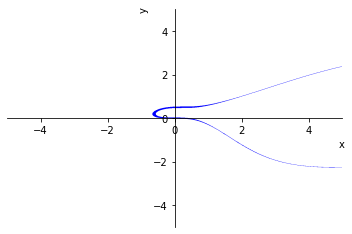

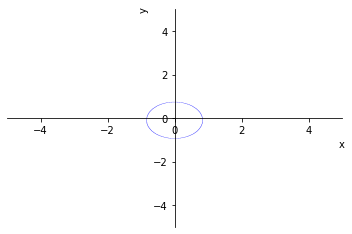

In [29]:
# график f = 0
plot_implicit(Eq(f, 0))
plt.show()
# график g = 0
plot_implicit(Eq(g, 0))
plt.show()